# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k

Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`

ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-mulitome-ATAC-ArchR-preprocessing.R

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [6]:
data_dir = '/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/ArchR/tcell_dep_ncrna/export/'

Load all the exported results from ArchR

### Peaks data

In [7]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [8]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
gene_scores = mmread(data_dir + "gene_scores/scores.mtx")
#imputed_scores = pd.read_csv(data_dir + 'imputed_scores.csv')
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()


,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:804692-805192,chr1,804692,805192,501,*,11.79249,0.402,0.208,2,C12._.rep1,FAM87B,12429,Distal,9,uc057aum.1,0.4012,1,0
chr1:816093-816593,chr1,816093,816593,501,*,33.55504,0.638,0.518,2,C5._.rep1,FAM87B,1028,Promoter,1027,uc057aum.1,0.2874,2,0
chr1:817087-817587,chr1,817087,817587,501,*,77.20024,0.933,0.881,2,C3._.rep2,FAM87B,34,Promoter,33,uc057aum.1,0.4770,3,0
chr1:821956-822456,chr1,821956,822456,501,*,4.20772,0.158,0.026,2,C2._.rep1,FAM87B,4835,Distal,2931,uc057aum.1,0.5489,4,0
chr1:827308-827808,chr1,827308,827808,501,*,75.11782,0.979,0.949,2,C10._.rep1,LINC01128,2420,Promoter,35,uc057auo.1,0.6966,5,0


In [9]:
deviations = pd.read_csv(data_dir + "deviations.csv", index_col = 0)
deviations

,seqnames,idx,name,combinedVars,combinedMeans,rank
f383,z,383,GATA1_383,107.058119,0.156540,1
f388,z,388,GATA2_388,104.362510,0.179807,2
f384,z,384,GATA3_384,76.274162,0.095589,3
f385,z,385,GATA5_385,50.397794,0.082385,4
f386,z,386,GATA4_386,48.000200,0.156978,5
...,...,...,...,...,...,...
f267,z,267,SP1_267,0.672398,0.060311,866
f178,z,178,MAZ_178,0.588632,-0.016904,867
f222,z,222,ZNF148_222,0.491794,0.013162,868
f158,z,158,ZFX_158,0.491093,0.002598,869


In [10]:
motif_scores = pd.read_csv(data_dir + "motif_scores.csv", index_col = 0 )
motif_scores

,rep1#GTGAGCGAGTCTCACC-1,rep1#GAGTCAAAGTCCTTCA-1,rep1#TGTGCGCAGTCGCTAG-1,rep1#ATATGTCCAATGCCTA-1,rep1#CTTAGTTTCGCTAGTG-1,rep1#ACCTCACTCGCAGGCT-1,rep1#CCACTTGGTACCGGAT-1,rep1#CGAATCTAGTCGCTAG-1,rep1#TGGTTCTGTTCAAGAT-1,rep1#GTTTAGCAGACTTACA-1,...,rep2#GTCTTGCTCACTAGGT-1,rep2#CGCAATTAGGGATTAG-1,rep2#CTTAAGGGTGCTTACT-1,rep2#CAGGCTGGTCCACAAA-1,rep2#CTAGTAATCGCATCCT-1,rep2#ATCCGTGAGGGATTAG-1,rep2#ATTTAGGTCAGGTTTA-1,rep2#GATGGACAGATAAAGC-1,rep2#GAAGGCTAGCTATATG-1,rep2#AGACAATAGGCTCATG-1
GATA1_383,-1.921714,50.729989,20.141371,-4.957698,17.185840,-4.405488,-4.408023,7.255691,-1.470502,-2.482050,...,4.688945,-2.495824,-0.356026,0.463526,-1.722157,-1.115614,-1.871718,0.360759,1.159423,-0.249281
GATA2_388,-2.439591,50.650894,20.546699,-3.560609,14.422498,-3.993053,-5.350048,8.645149,-2.387690,-2.765377,...,4.008186,-0.726424,-1.006938,-0.681992,-1.316376,-1.172853,-1.505243,0.109250,0.440207,-0.171401
GATA3_384,-2.158230,36.349220,14.456918,-4.665156,15.767896,-3.921837,-5.360318,5.999107,-1.962576,-2.412512,...,3.825000,-0.226199,0.726809,0.987321,-0.925419,-1.259342,-0.739054,-0.618239,-0.508868,0.981997
GATA5_385,-1.599354,34.658788,10.279370,-2.859407,11.204451,-2.336883,-5.855758,7.772492,0.165351,-3.093593,...,5.157772,-0.453336,1.232054,1.866589,-0.518997,-1.435193,-0.321454,0.614400,3.265555,-0.072244
GATA4_386,-1.046410,35.660472,13.923303,-2.645815,15.161747,-0.220946,-2.470052,3.250743,-0.879935,-3.304371,...,2.346901,-1.204853,-0.796293,-0.248492,-0.521686,-0.426363,-0.814565,-0.674797,-0.578496,0.075541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP1_267,-2.263583,-1.321387,-0.378627,-0.520041,-1.233311,-1.491644,-1.693012,-1.542245,-3.377282,-0.266840,...,0.438530,0.112647,0.105801,0.707604,-0.989965,-0.051246,0.622228,-0.010067,-0.934836,-0.791684
MAZ_178,0.521018,-0.996276,-1.776338,-0.749341,-1.254966,-1.082297,0.486784,0.971686,-0.190325,1.167390,...,-0.449022,0.062338,-0.418631,0.346732,-0.649678,-0.551069,0.059124,1.150800,-0.538501,-0.600188
ZNF148_222,-0.146455,-1.275467,-1.700877,0.625239,-1.367941,-1.610306,-0.031266,1.317556,-0.882120,0.566307,...,-0.266162,-0.254785,0.327555,0.402998,-1.210031,-0.377632,-0.707724,0.434230,-0.442149,0.804793
ZFX_158,-1.750144,1.328805,0.588673,-1.094223,2.489023,-0.749592,-1.257469,-0.223211,0.707420,-0.914529,...,0.534260,-0.153205,0.292797,-0.646725,0.707460,-0.640803,-0.623100,-0.518209,-0.419919,0.503460


### Gene scores

In [11]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

/loc/scratch/4247440/ipykernel_11161/1812160205.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [12]:
ad.uns['deviations'] = deviations

In [13]:
ad.X = ad.X.tocsr()

In [14]:
ad.var_names

Index(['chr1:804692-805192', 'chr1:816093-816593', 'chr1:817087-817587',
       'chr1:821956-822456', 'chr1:827308-827808', 'chr1:829874-830374',
       'chr1:831520-832020', 'chr1:838245-838745', 'chr1:842735-843235',
       'chr1:856525-857025',
       ...
       'chrX:155843018-155843518', 'chrX:155873081-155873581',
       'chrX:155881032-155881532', 'chrX:155886536-155887036',
       'chrX:155888144-155888644', 'chrX:155889265-155889765',
       'chrX:155891422-155891922', 'chrX:155893560-155894060',
       'chrX:155899254-155899754', 'chrX:155966817-155967317'],
      dtype='object', length=216477)

In [15]:
gene_scores = mmread(data_dir + "gene_scores/scores.mtx")

In [16]:
chrs = list()
for i in range(1,23):
    chrs.append(f'chr{i}')
chrs.append('chrX')
chrs.append('chrY')
chrs

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY']

In [17]:
tsv= pd.read_csv('/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/features.tsv', sep = '\t')
#tsv = tsv.drop('0')
#tsv
#tsv.drop('0', axis= 1)
#tsv.index = tsv['ENSEMBL ID']
tsv = tsv[['Chromosome', 'Start', 'End', 'gene_name', 'Feature Type', 'ENSEMBL ID']]
tsv = tsv[tsv['Chromosome'].isin(chrs)]

gene_names = tsv['gene_name']
gene_names.index = tsv['ENSEMBL ID']

In [18]:
gene_names['ENSG00000239945']

'AL627309.3'

In [19]:
genes = pd.read_csv(data_dir + "gene_scores/genes.csv")
genes = genes['x']
genes = genes.replace('^NA_E', 'E', regex = True)


In [20]:
for i in genes[genes.isin(gene_names.keys()) == True].index:
    genes[i] = gene_names[genes[i]]
genes

0         MIR1302-2HG
1             FAM138A
2               OR4F5
3        LOC100996442
4          AL627309.3
             ...     
35176           TMLHE
35177           SPRY3
35178           VAMP7
35179            IL9R
35180          WASIR1
Name: x, Length: 35181, dtype: object

In [22]:
cells = pd.read_csv(data_dir + "gene_scores/cells.csv")
gene_scores = pd.DataFrame(gene_scores.todense().T, index = cells['x'], columns = genes)



In [23]:
gene_scores

x,MIR1302-2HG,FAM138A,OR4F5,LOC100996442,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,F8A2,F8A3,H2AB3,TMLHE-AS1,BX571846.1,TMLHE,SPRY3,VAMP7,IL9R,WASIR1
x,,,,,,,,,,,,,,,,,,,,,
rep1#GTGAGCGAGTCTCACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.158,0.186,0.183,0.028,0.0
rep1#GAGTCAAAGTCCTTCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.165,0.103,0.0,0.000,0.0,0.000,0.000,0.122,0.000,0.0
rep1#TGTGCGCAGTCGCTAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.126,0.121,0.0,0.000,0.0,0.000,0.000,0.261,0.062,0.0
rep1#ATATGTCCAATGCCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.122,0.0,0.187,0.033,0.000,0.000,0.0
rep1#CTTAGTTTCGCTAGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.171,0.121,0.0,0.000,0.0,0.000,0.150,0.676,0.196,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rep2#ATCCGTGAGGGATTAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0
rep2#ATTTAGGTCAGGTTTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0
rep2#GATGGACAGATAAAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0


In [24]:
#imputed_scores.drop('Unnamed: 0')

In [25]:

#imputed_scores = imputed_scores.T
#imputed_scores = imputed_scores.drop('Unnamed: 0', axis = 0)
#imputed_scores.index = gene_scores.index
#imputed_scores


In [26]:
ad.obsm['GeneScores'] = np.array(gene_scores)
ad.uns['GeneScoresColumns'] = gene_scores.columns.values
ad.obsm['GeneScores']

array([[0.   , 0.   , 0.   , ..., 0.183, 0.028, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.122, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.261, 0.062, 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [31]:
ad.uns['GeneScoresColumns']

array(['MIR1302-2HG', 'FAM138A', 'OR4F5', ..., 'VAMP7', 'IL9R', 'WASIR1'],
      dtype=object)

In [32]:
ad.obsm['MotifScores'] = motif_scores.T.loc[ad.obs_names, :].values
ad.uns['MotifScoresColumns'] = motif_scores.T.columns.values

In [33]:
ad.obs_names

Index(['rep1#GTGAGCGAGTCTCACC-1', 'rep1#GAGTCAAAGTCCTTCA-1',
       'rep1#TGTGCGCAGTCGCTAG-1', 'rep1#ATATGTCCAATGCCTA-1',
       'rep1#CTTAGTTTCGCTAGTG-1', 'rep1#ACCTCACTCGCAGGCT-1',
       'rep1#CCACTTGGTACCGGAT-1', 'rep1#CGAATCTAGTCGCTAG-1',
       'rep1#TGGTTCTGTTCAAGAT-1', 'rep1#GTTTAGCAGACTTACA-1',
       ...
       'rep2#GTCTTGCTCACTAGGT-1', 'rep2#CGCAATTAGGGATTAG-1',
       'rep2#CTTAAGGGTGCTTACT-1', 'rep2#CAGGCTGGTCCACAAA-1',
       'rep2#CTAGTAATCGCATCCT-1', 'rep2#ATCCGTGAGGGATTAG-1',
       'rep2#ATTTAGGTCAGGTTTA-1', 'rep2#GATGGACAGATAAAGC-1',
       'rep2#GAAGGCTAGCTATATG-1', 'rep2#AGACAATAGGCTCATG-1'],
      dtype='object', name='x', length=8627)

In [34]:
ad.uns['MotifScoresColumns']

array(['GATA1_383', 'GATA2_388', 'GATA3_384', 'GATA5_385', 'GATA4_386',
       'CEBPA_155', 'GATA6_387', 'CEBPB_140', 'CEBPD_152', 'JUND_124',
       'SMARCC1_651', 'JUNB_139', 'SPI1_322', 'FOSL1_142', 'FOSL2_105',
       'SPIB_336', 'JUN_143', 'FOS_137', 'TCF4_97', 'BACH1_130',
       'TCF12_56', 'BCL11A_194', 'BCL11B_825', 'LMO2_808', 'MESP1_69',
       'MESP2_94', 'ID3_38', 'ID4_75', 'CEBPG_128', 'ATOH8_71',
       'FOSB_121', 'SPIC_344', 'BACH2_113', 'MECOM_169', 'MYOD1_48',
       'ASCL1_843', 'SNAI1_199', 'TCF3_21', 'CEBPE_107', 'JDP2_125',
       'ASCL2_89', 'MYOG_41', 'NHLH1_74', 'LYL1_818', 'NHLH2_80',
       'NFE2_119', 'ATF4_122', 'NEUROD1_63', 'TAL1_62', 'TAL2_822',
       'NFE2L2_115', 'IRF4_632', 'ZEB1_157', 'STAT2_778', 'FIGLA_88',
       'EBF1_67', 'NFIX_738', 'TFAP4_23', 'MYF5_842', 'RUNX2_732',
       'ENSG00000250096_734', 'TWIST1_42', 'IRF1_629', 'PRDM16_211',
       'FERD3L_58', 'ELF2_326', 'RELA_722', 'MSC_82', 'TCF21_39',
       'ENSG00000187728_92', 'HLF_112', '

In [35]:
#imputed_scores.index=gene_scores.index

In [36]:
#imputed_scores = imputed_scores.drop('Unnamed: 0',axis = 1)

In [37]:
#np.shape(imputed_scores)
#np.shape(gene_scores)
#imputed_scores

In [38]:
#imputed_scores.columns = gene_scores.columns

### SVD

In [39]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [40]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [41]:
ad

AnnData object with n_obs × n_vars = 8627 × 216477
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'deviations', 'GeneScoresColumns', 'MotifScoresColumns'
    obsm: 'GeneScores', 'MotifScores', 'X_svd'

In [42]:
ad.raw = ad

# Preprocessing

In [43]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

2022-11-21 14:45:17.139069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 14:45:19.964447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 14:45:19.964479: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 14:45:20.171143: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [44]:
# Phenograph
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_svd'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5693771839141846 seconds


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x146020144400>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x145ec3f7d640>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x145f23143fa0>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x146020144400>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x145ec3f7d640>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70:

Jaccard graph constructed in 2.1820228099823 seconds
Wrote graph to binary file in 0.1634960174560547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.840596
After 4 runs, maximum modularity is Q = 0.84397
Louvain completed 24 runs in 7.887771844863892 seconds
Sorting communities by size, please wait ...


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x146020144400>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x145ec3f7d640>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x145f23143fa0>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x146020144400>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x145ec3f7d640>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70:

PhenoGraph completed in 12.943645715713501 seconds


In [45]:
# Diffusion maps
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors']  = dm_res['EigenVectors'].values
ad.uns['DM_EigenValues']  = dm_res['EigenValues'].values

Determing nearest neighbor graph...


# Visualizations

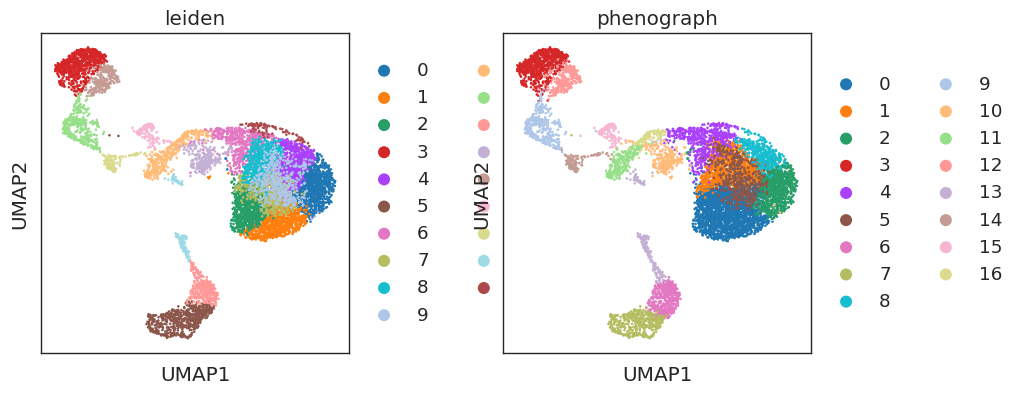

In [46]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

In [47]:
ad.obsm['GeneScores']

array([[0.   , 0.   , 0.   , ..., 0.183, 0.028, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.122, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.261, 0.062, 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

# Save

In [48]:
ad

AnnData object with n_obs × n_vars = 8627 × 216477
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'deviations', 'GeneScoresColumns', 'MotifScoresColumns', 'neighbors', 'umap', 'leiden', 'DM_EigenValues', 'leiden_colors', 'phenograph_colors'
    obsm: 'GeneScores', 'MotifScores', 'X_svd', 'X_umap', 'DM_EigenVectors'
    obsp: 'distances', 'connectivities', 'DM_kernel'

In [49]:
ad.write('/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/data/tcell_dep_multiome_atac_ncrna.h5ad')